In [2]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sklearn as sk

# model

In [4]:
from model.main import SplitterNet

# data

## transform

In [5]:
from data.dataset import TransSqueeze, TransChunked

## dataset

In [6]:
from data.dataset import JVSDataset

# 入力確認

In [7]:
model = SplitterNet()
model.test_input()

encoder out *2
torch.Size([64, 64, 4, 4])
decoder out
torch.Size([64, 1, 32, 32])


# eval

In [8]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [9]:
import glob
pa = glob.glob("logs/lightning_logs/version_86/checkpoints/epoch=*.ckpt")[-1]

In [10]:
model = model.load_from_checkpoint(pa)

In [11]:
model.eval()

SplitterNet(
  (content_encoder): ContentEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 32, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 64, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (attribute_encoder): AttributeEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(3, 9),

In [12]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [13]:
x = torchaudio.load(wav_paths.collect_files()[101])[0][:, :159377]
tmp = torchaudio.load(wav_paths.collect_files()[303])[0]

In [23]:
def change(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    sp = torch.from_numpy(sp).T.to(torch.float)
    mel = torchaudio.transforms.MelScale(sample_rate=24000, n_mels=32, n_stft=513)
    invmel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=32)
    sp = invmel(mel(sp))
    sp = sp.T.to(torch.double).numpy()
    return f0, sp, ap

## 元音声の再合成

In [25]:
f0, sp, ap = change(x) 

In [27]:
xx = pw.synthesize(f0, sp.astype('float'), ap, 24000)

In [30]:
xx

array([nan, nan, nan, ..., nan, nan, nan])

In [28]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

(1, 159480)


/tmp/ipykernel_4180464/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


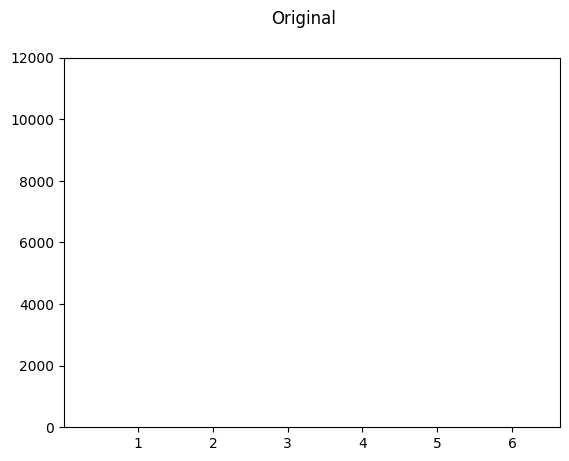

In [29]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [18]:
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

[[7.02180667e-08 7.00443101e-08 6.95854043e-08 ... 9.82380389e-11
  9.80887072e-11 9.80389366e-11]
 [2.98516171e-07 2.95934698e-07 2.89054637e-07 ... 8.77787991e-10
  8.78143998e-10 8.78262221e-10]
 [4.73407771e-07 4.74911065e-07 4.79210260e-07 ... 9.34613738e-10
  9.31850976e-10 9.30930666e-10]
 ...
 [3.54152940e-07 3.55410130e-07 3.58947153e-07 ... 5.82273243e-10
  5.81400450e-10 5.81109672e-10]
 [1.82641909e-06 1.81116693e-06 1.77121180e-06 ... 5.57291343e-10
  5.56669428e-10 5.56462237e-10]
 [1.03925568e-06 1.03729368e-06 1.03215422e-06 ... 6.45207469e-10
  6.43359525e-10 6.42744137e-10]]


In [19]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 159480)


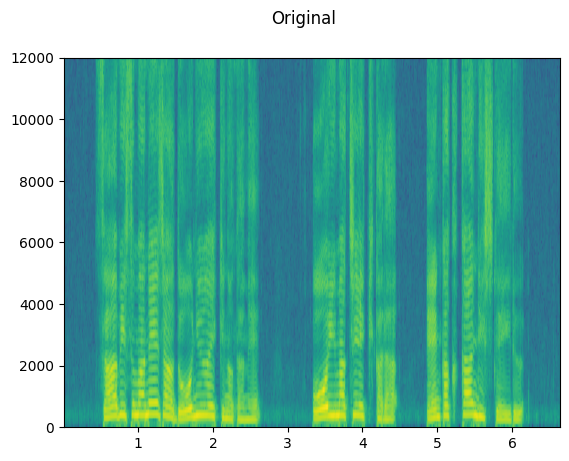

In [20]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [21]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), x_mc.unsqueeze(0).unsqueeze(0).to(torch.float)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [22]:
yy = synth(y_mc, x_f0, x_ap)

[[1.63558349e-13 2.36061279e-13 6.87085263e-13 ... 1.15873546e-15
  1.15883890e-15 1.15887416e-15]
 [1.19064928e-13 1.41727125e-13 2.35738214e-13 ... 1.59599365e-11
  1.59757520e-11 1.59810342e-11]
 [5.38288760e-14 6.82980013e-14 1.37063592e-13 ... 5.56671376e-17
  5.53281987e-17 5.52156095e-17]
 ...
 [1.06284048e-09 1.17528820e-09 1.58293867e-09 ... 6.91359405e-13
  6.85345498e-13 6.83350349e-13]
 [8.39034087e-09 1.12298322e-08 2.61123621e-08 ... 4.31025918e-12
  4.31519230e-12 4.31683899e-12]
 [2.40235938e-08 2.77324741e-08 4.20734594e-08 ... 5.15294807e-10
  5.11013065e-10 5.09592424e-10]]


In [23]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 159480)


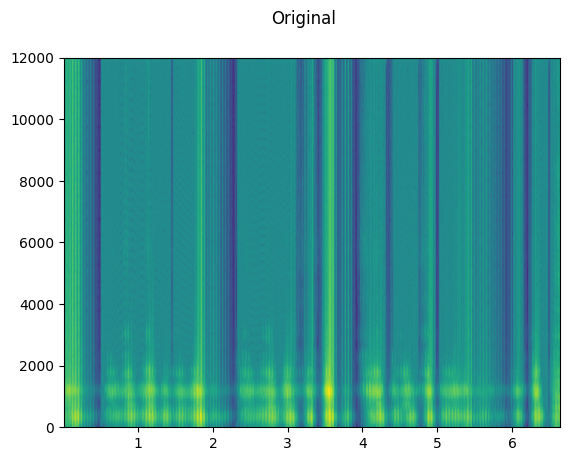

In [24]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")